In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
img_dir = '/content/drive/MyDrive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized'
annotation_file = '/content/drive/MyDrive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized/All_in_1_Skin_Diseases_METADATA.csv'


In [ ]:
# obtain the name of diseases

#modified here...
# try:
#     df = pd.read_csv(annotation_file, encoding='latin1')
# except UnicodeDecodeError:
#     print("Failed to read CSV file with 'latin1' encoding. Trying 'utf-8'.")
#     df = pd.read_csv(annotation_file, encoding='utf-8')

list_diseases = list(pd.read_csv(annotation_file)["diagnosis"].unique())

# list_diseases = list(df["diagnosis"].unique())
print(len(list_diseases))
print(list_diseases)

15
['Actinic Keratosis', 'Basal Cell Carcinoma', 'Dermato Fibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion', 'Eczema', 'Atopic Dermatitis', 'Psoriasis', 'Tinea Ringworm Candidiasis', 'Warts Molluscum', 'Acne/Pimples']


In [ ]:
import torch
# Define the dataset class
class SkinCareDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):  #modified here... i put encoding = 'latin1'
        self.annotations = pd.read_csv(annotations_file)
        self.annotations = self.annotations[:-1]
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        img_name += '.jpg'  # Add the file extension
        image = Image.open(img_name).convert("RGB")
        disease = self.annotations.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        label = torch.zeros(len(list_diseases))
        label[list_diseases.index(disease)] = 1

        return image, label


In [ ]:
# initialize the dataloader

dataset = SkinCareDataset(annotation_file, img_dir, transform)

In [ ]:
# split the data into training testing and validation
import torch
from torch.utils.data import random_split, DataLoader

# Assuming `dataset` is your dataset object
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_val_size = dataset_size - test_size

# First, split into train+val and test sets
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Now, split the train_val set into train and validation sets
train_size = int(0.8 * train_val_size)
val_size = train_val_size - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')


Training batches: 20
Validation batches: 5


In [ ]:
# load efficientnet model
import torchvision.models as models
image_model = models.efficientnet_b0(pretrained=True)

# freeze the parameters
for param in image_model.parameters():
    param.requires_grad = False

# replace the last fully connected layer
num_features = image_model.classifier[1].in_features
image_model.classifier[1] = torch.nn.Linear(num_features, len(list_diseases))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 167MB/s]


In [ ]:
#Train.py

import torch.optim as optim
optimizer = optim.Adam(image_model.parameters(), lr=0.001)

# #adding a learning rate scheduler #updated biraj
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# #early stopping implementation
# # best_val_loss = float('inf')
# patience = 10
# no_improvement_count = 0

from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
print(f"CUDA device count: {torch.cuda.device_count()}")

# Move the model to the device (GPU or CPU)
image_model.to(device)


#initialize loss function
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

# finetune the model
def train(num_epochs, start_epoch):
    best_val_loss = float('inf') #best_val_loss is set to very higher +ve value

    for epoch in range(start_epoch,num_epochs):
      image_model.train()  #training phase suru
      running_train_loss = 0.0
      train_loader_tqdm = tqdm(train_loader, desc = f'Train Epoch {epoch+1}/{num_epochs}')
      for images, labels in train_loader_tqdm:
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = image_model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_train_loss += loss.item()
          train_loader_tqdm.set_postfix(loss=loss.item())

      #Validation Phase  added to check each epoch performance  #updated biraj
      image_model.eval()
      running_val_loss=0.0 # accumulating the total validation loss over all the batches.
      # correct= 0
      # total = 0
      val_loader_tqdm = tqdm(val_loader, desc= 'Validation')
      with torch.no_grad():
        for images, labels in val_loader_tqdm:
          images, labels = images.to(device), labels.to(device)

          outputs=image_model(images)
          loss= criterion(outputs,labels)
          running_val_loss+=loss.item()
          _, predicted = torch.max(outputs, 1)


          if predicted.size(0) != labels.size(0):
              print(f"Batch size mismatch: predicted size {predicted.size(0)}, labels size {labels.size(0)}")
              continue
          # total+= labels.size(0)
          # correct+=(predicted ==labels).sum().item()
          # val_loader_tqdm.set_postfix(loss=loss.item())


      epoch_train_loss = running_train_loss / len(train_loader)
      epoch_val_loss = running_val_loss / len(val_loader)
      # val_accuracy = 100 * correct / total


      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')


     # Save the model after training and only if the validation loss decreases than the previous one
    # Save the model if validation loss decreases
      if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            print("Process of Saving the model starts from here")
            modelPath = '/content/drive/My Drive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized/modelFile.pth'
            torch.save(image_model.state_dict(), modelPath)
            local_model_path = '/content/modelFile.pth'

            # Save the model state dictionary locally
            torch.save(image_model.state_dict(), local_model_path)
            start_epoch+=1
            # torch.save(
            #         {
            #             'model':image_model.state_dict(),
            #             'optimizer':optimizer.state_dict(),
            #             'epoch':epoch+1

            #         },
            #         modelPath
            #     )
            # print("Model is saved....")


# modelPath = '/content/drive/My Drive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized/modelFile.pth'
start_epoch = 0

# if os.path.exists(modelPath):
#       print("Loading the trained params and the state of optimizer...")
#       '''
#       start_iter = load_ckpt([("model", model)],
#                                [("optimizer", optimizer)])
#                                '''

#       checkpoint = (torch.load(modelPath))
#       image_model.load_state_dict(checkpoint['model'])
#       optimizer.load_state_dict(checkpoint['optimizer'])
#       start_epoch = checkpoint['epoch']


#Comment it to RUN the final Prediction Model
# train(100, start_epoch)


Using device: cuda
CUDA device count: 1


In [ ]:
#Final_Prediction_Model.py
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image

# Define the image transformations (should match those used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the trained model
model_path = '/content/drive/My Drive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized/modelFile.pth'
num_classes = len(list_diseases)  # Ensure this matches your number of classes
image_model = models.efficientnet_b0(pretrained=False)
num_features = image_model.classifier[1].in_features
image_model.classifier[1] = torch.nn.Linear(num_features, num_classes)
image_model.load_state_dict(torch.load(model_path))
image_model.eval()

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model.to(device)

def predict(image_path, model, transform, device, list_diseases):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Move the image to the device
    image = image.to(device)

    # Run the image through the model
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)


    # Get the predicted class index
    confidence, predicted = torch.max(probabilities, 1)
    predicted_class = list_diseases[predicted.item()]
    confidence = confidence.item() * 100

    return predicted_class, confidence


image_path = '/content/drive/My Drive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized/TestingSamples/pimple1.jpg'  # Replace with the path to your image
predicted_class, confidence = predict(image_path, image_model, transform, device, list_diseases)
print(f'The model predicts the Skin Disease class as: {predicted_class} with a confidence of {confidence:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The model predicts the Skin Disease class as: Acne/Pimples with a confidence of 94.54%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


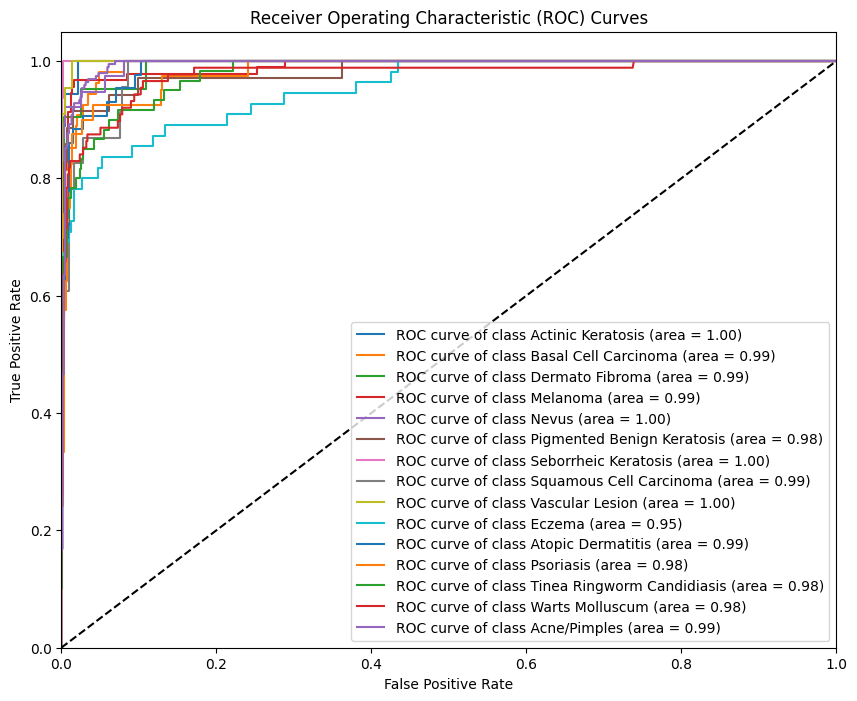

In [ ]:
import torch
from torchvision import models, transforms
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image

# Assume list_diseases and the necessary imports are already defined above
# list_diseases = ['disease1', 'disease2', ..., 'disease15']

# Define the image transformations (should match those used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the trained model
model_path = '/content/drive/My Drive/All_in1-Skin Diseases(3000 files)[224 by 224]Resized/modelFile.pth'
num_classes = len(list_diseases)
image_model = models.efficientnet_b0(pretrained=False)
num_features = image_model.classifier[1].in_features
image_model.classifier[1] = torch.nn.Linear(num_features, num_classes)
image_model.load_state_dict(torch.load(model_path))
image_model.eval()

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model.to(device)

# Assume test_dataset and test_loader are already defined
# test_dataset = YourDatasetClass(...)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation and ROC Curve Calculation
all_labels = []
all_probs = []

image_model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = image_model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {list_diseases[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
